# <font color='yellow'> Set-up HIP </font> 

In [39]:
import sys

sys.path.append("../")

import warnings
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from pathlib import Path
from utils import hparam_tunning

from sklearn.exceptions import FitFailedWarning
from sklearn.model_selection import train_test_split

from sksurv.util import Surv
from sksurv.metrics import concordance_index_censored
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.ensemble import RandomSurvivalForest, GradientBoostingSurvivalAnalysis, ComponentwiseGradientBoostingSurvivalAnalysis

%matplotlib inline
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FitFailedWarning)

sns.set(style="darkgrid", rc = {"figure.figsize": (10, 10)})

SEED = 1234
np.random.seed(SEED)

data_path = Path("./data/hip/")

surv_data = pd.read_csv(data_path / "surv_data_hip.csv", index_col="studyid")
X = surv_data.drop(columns=["status", "time"])
y = Surv.from_dataframe(event = "status", time = "time", data = surv_data_mof)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# <font color='yellow'> 1. COX-PH </font> 

In [2]:
from sksurv.linear_model import CoxPHSurvivalAnalysis

estimator = CoxPHSurvivalAnalysis()
estimator.fit(X_train, y_train) 

CoxPHSurvivalAnalysis()

In [3]:
print(f"C-Index score \n train: {estimator.score(X_train, y_train)} \n test: {estimator.score(X_test, y_test)}")

C-Index score 
 train: 0.9034611393247348 
 test: 0.5991565368394939


<AxesSubplot:>

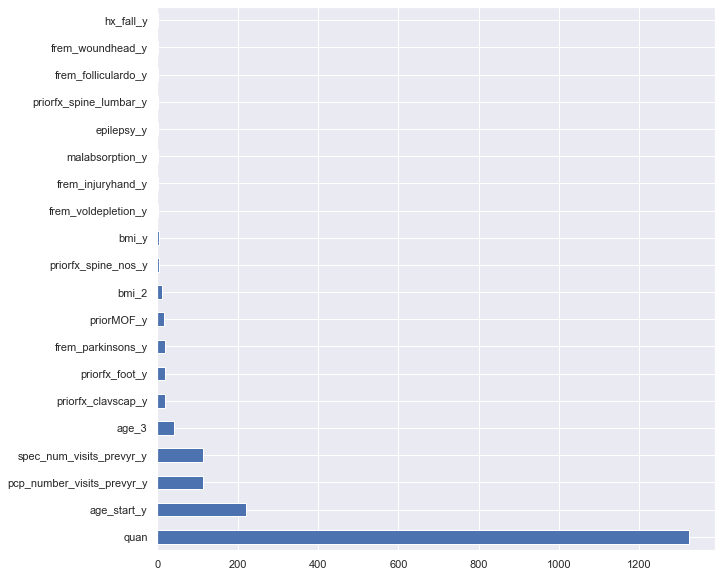

In [4]:
hazard_ratio = pd.Series(estimator.coef_, index=X_train.columns)
hazard_ratio.sort_values(ascending=False, inplace=True)
hazard_ratio[:20].plot.barh()

# <font color='yellow'> 2. COX-PH Ridge </font> 

In [5]:
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sklearn.model_selection import cross_validate, KFold

alphas = 10. ** np.linspace(-4, 4, 50)
kf = KFold(n_splits = 5, shuffle = True)    
scores = {'alpha': [], 
           'score': [], 
           'std': []}

for alpha in tqdm(alphas, desc = "alpha tunning: "):
    estimator = CoxPHSurvivalAnalysis(alpha = alpha)
    cv_res = cross_validate(estimator, X_train, y_train, cv = kf, error_score=0.5, n_jobs=-1)
    scores['alpha'].append(round(alpha, 5))
    scores['score'].append(np.mean(cv_res['test_score']))
    scores['std'].append(np.std(cv_res['test_score']))
    
scores = pd.DataFrame.from_dict(scores)

alpha tunning:   0%|          | 0/50 [00:00<?, ?it/s]/usr/local/anaconda3/envs/Fracture/lib/python3.8/site-packages/sksurv/linear_model/coxph.py:174: RuntimeWarning: overflow encountered in exp
  risk_set += numpy.exp(xw[k])
/usr/local/anaconda3/envs/Fracture/lib/python3.8/site-packages/sksurv/linear_model/coxph.py:174: RuntimeWarning: overflow encountered in exp
  risk_set += numpy.exp(xw[k])
/usr/local/anaconda3/envs/Fracture/lib/python3.8/site-packages/sksurv/linear_model/coxph.py:171: RuntimeWarning: overflow encountered in exp
  risk_set2 += numpy.exp(xw[k])
/usr/local/anaconda3/envs/Fracture/lib/python3.8/site-packages/sksurv/linear_model/coxph.py:171: RuntimeWarning: overflow encountered in exp
  risk_set2 += numpy.exp(xw[k])
/usr/local/anaconda3/envs/Fracture/lib/python3.8/site-packages/sksurv/linear_model/coxph.py:174: RuntimeWarning: overflow encountered in exp
  risk_set += numpy.exp(xw[k])
/usr/local/anaconda3/envs/Fracture/lib/python3.8/site-packages/sksurv/linear_model/co

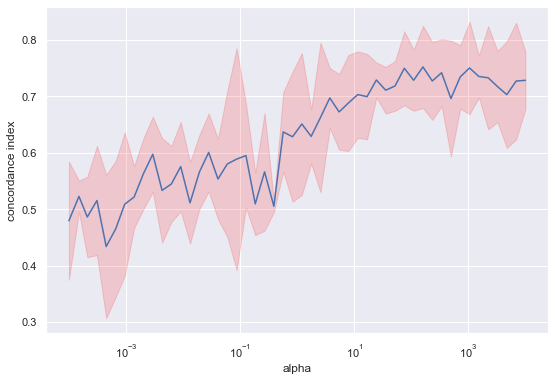

In [6]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(scores['alpha'],scores['score'])
ax.fill_between(scores['alpha'], scores['score'] - scores['std'], scores['score'] + scores['std'], alpha=0.15, color = "red")
ax.set_xscale("log")
ax.set_ylabel("concordance index")
ax.set_xlabel("alpha")
ax.grid(True)

C-Index score 
 train: 0.7863108187467175 
 test: 0.8011907715207145


<AxesSubplot:>

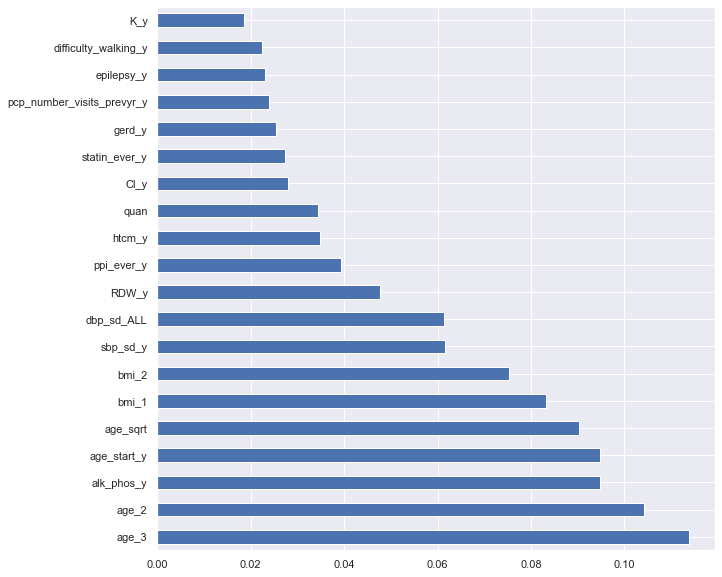

In [7]:
estimator = CoxPHSurvivalAnalysis(alpha = scores.alpha[np.argmax(scores.score)])
estimator.fit(X_train, y_train)

print(f"C-Index score \n train: {estimator.score(X_train, y_train)} \n test: {estimator.score(X_test, y_test)}")

hazard_ratio = pd.Series(estimator.coef_, index=X_train.columns)
hazard_ratio.sort_values(ascending=False, inplace=True)
hazard_ratio[:20].plot.barh()

# <font color='yellow'> 3. COX-PH Lasso </font> 

In [8]:
alphas = 10. ** np.linspace(-4, 1, 50)
kf = KFold(n_splits = 5, shuffle = True)    
scores = {'alpha': [], 
           'score': [], 
           'std': []}

for alpha in tqdm(alphas, desc = "alpha tunning: "):
    estimator = CoxnetSurvivalAnalysis(alphas = [alpha], l1_ratio=1)
    cv_res = cross_validate(estimator, X_train, y_train, cv = kf, error_score=0.5, n_jobs=-1)
    scores['alpha'].append(round(alpha, 5))
    scores['score'].append(np.mean(cv_res['test_score']))
    scores['std'].append(np.std(cv_res['test_score']))
    
scores = pd.DataFrame.from_dict(scores)

alpha tunning:   0%|          | 0/50 [00:00<?, ?it/s]/usr/local/anaconda3/envs/Fracture/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=100000).
  estimator.fit(X_train, y_train, **fit_params)
alpha tunning:   4%|▍         | 2/50 [01:27<30:05, 37.61s/it]  /usr/local/anaconda3/envs/Fracture/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=100000).
  estimator.fit(X_train, y_train, **fit_params)
alpha tunning:   8%|▊         | 4/50 [02:22<21:13, 27.69s/it]/usr/local/anaconda3/envs/Fracture/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=100000).
  estimator.fit(X_train, y_train, **fit_

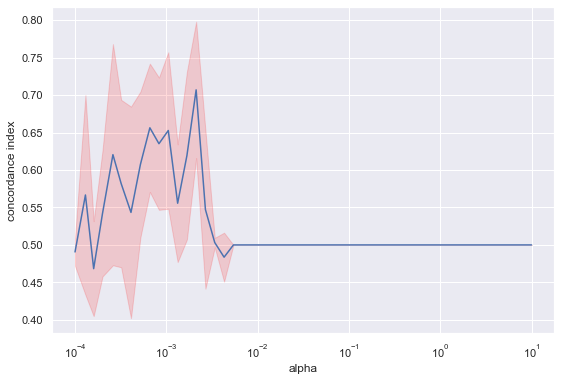

In [9]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(scores['alpha'],scores['score'])
ax.fill_between(scores['alpha'], scores['score'] - scores['std'], scores['score'] + scores['std'], alpha=0.15, color = "red")
ax.set_xscale("log")
ax.set_ylabel("concordance index")
ax.set_xlabel("alpha")
ax.grid(True)

C-Index score 
 train: 0.7358561254592615 
 test: 0.7918134457950881


<AxesSubplot:>

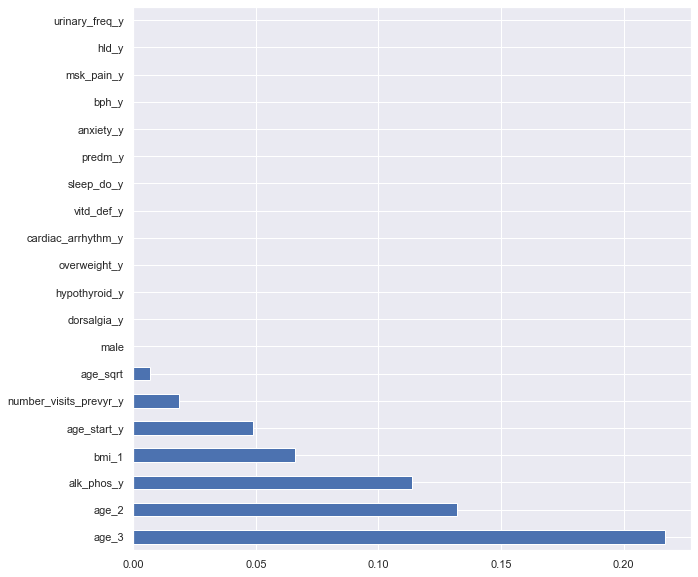

In [10]:
estimator = CoxnetSurvivalAnalysis(alphas = [scores.alpha[np.argmax(scores.score)]])
estimator.fit(X_train, y_train)

print(f"C-Index score \n train: {estimator.score(X_train, y_train)} \n test: {estimator.score(X_test, y_test)}")

hazard_ratio = pd.Series(estimator.coef_[:, 0], index=X_train.columns)
hazard_ratio.sort_values(ascending=False, inplace=True)
hazard_ratio[:20].plot.barh()

# <font color='yellow'> 4. COX-PH ElasticNet </font> 

In [11]:
ratios = np.linspace(0.1, 0.9, 10)
alphas = 10. ** np.linspace(-4, 4, 50)
scores = np.zeros((10, 50))

kf = KFold(n_splits = 5, shuffle = True)    

for i, ratio in enumerate(ratios):
    for j, alpha in enumerate(alphas):
        estimator = CoxnetSurvivalAnalysis(alphas = [alpha], l1_ratio = ratio)
        cv_res = cross_validate(estimator, X_train, y_train, cv = kf, error_score=0.5, n_jobs=-1)
        scores[i, j] = np.mean(cv_res['test_score'])

/usr/local/anaconda3/envs/Fracture/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=100000).
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/anaconda3/envs/Fracture/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=100000).
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/anaconda3/envs/Fracture/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=100000).
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/anaconda3/envs/Fracture/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: UserWarning: all coefficients are zero, consider decreasing al

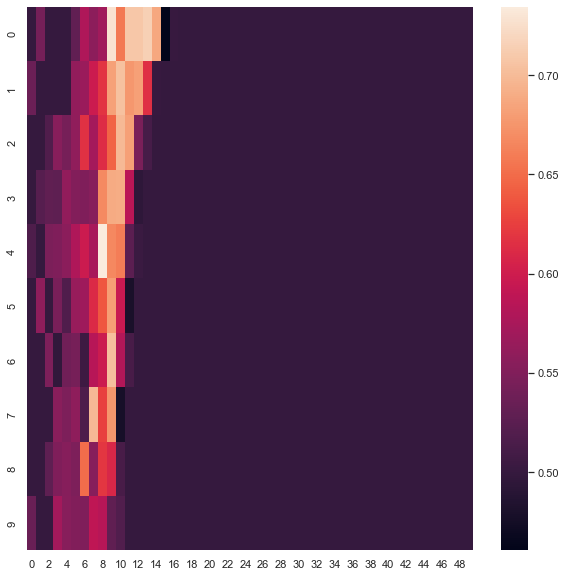

In [12]:
ax = sns.heatmap(scores)

C-Index score 
 train: 0.7431204152861528 
 test: 0.7943438352766063


<AxesSubplot:>

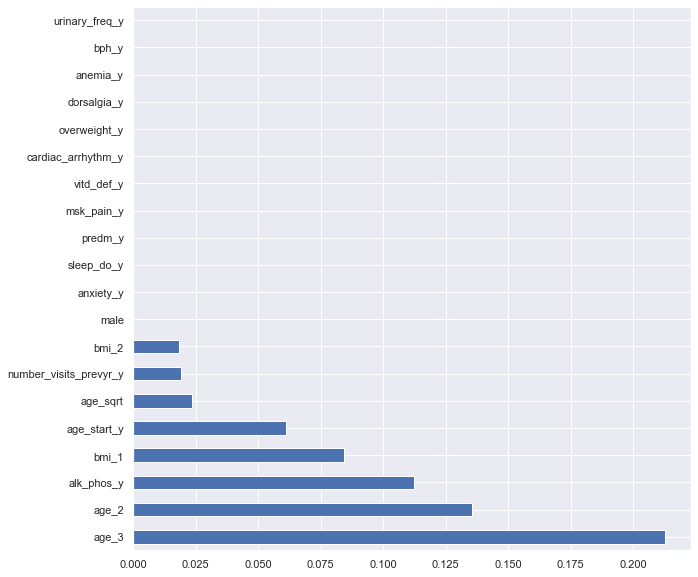

In [13]:
ind = np.unravel_index(np.argmax(scores, axis=None), scores.shape)
estimator = CoxnetSurvivalAnalysis(alphas = [alphas[ind[1]]], l1_ratio = ratios[ind[0]])

estimator.fit(X_train, y_train)

print(f"C-Index score \n train: {estimator.score(X_train, y_train)} \n test: {estimator.score(X_test, y_test)}")

hazard_ratio = pd.Series(estimator.coef_[:, 0], index=X_train.columns)
hazard_ratio.sort_values(ascending=False, inplace=True)
hazard_ratio[:20].plot.barh()

# <font color='yellow'> 5. Random Surv Forest </font> 

In [3]:
rsf = RandomSurvivalForest(verbose = 0, n_jobs = -1, max_features=None, n_estimators=100, max_depth=8)
rsf.fit(X_train, y_train)
        
train_score = rsf.score(X_train, y_train)
test_score = rsf.score(X_test, y_test)

print(f"train score = {train_score:.5f}; test score = {test_score:.5f}")

train score = 0.88576; test score = 0.78447


# <font color='yellow'> 7. Component Wide Gradient Boosting </font> 

In [4]:
estimator = ComponentwiseGradientBoostingSurvivalAnalysis(loss="coxph")
estimator.fit(X_train, y_train)

train_score = estimator.score(X_train, y_train)
test_score = estimator.score(X_test, y_test)

print(f"train score = {train_score:.5f}; test score = {test_score:.5f}")

train score = 0.69674; test score = 0.74169


n_estimators tunning: 100%|██████████| 6/6 [1:43:43<00:00, 1037.29s/it]


 0.69674;  0.74169


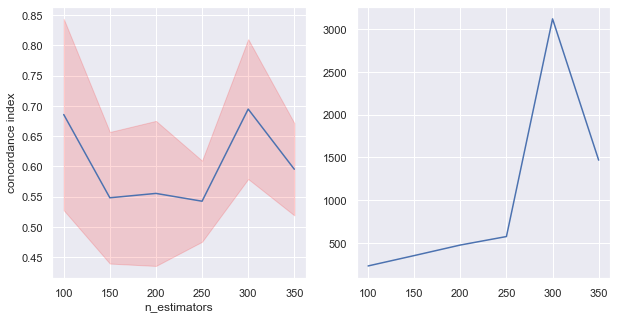

In [33]:
fixed_params = {"loss": "coxph", "random_state": SEED}
n_estimators = np.arange(100, 400, 50)
scores = hparam_tunning(search_space=n_estimators, fixed_params=fixed_params, estimator_engine=ComponentwiseGradientBoostingSurvivalAnalysis, name = "n_estimators", X_train=X_train, y_train=y_train)

fixed_params['n_estimators'] = scores.n_estimators[np.argmax(scores.score)]
estimator = ComponentwiseGradientBoostingSurvivalAnalysis(**fixed_params).fit(X_train, y_train)
print(f"{estimator.score(X_train, y_train): .5f}; {estimator.score(X_test, y_test): .5f}")

# <font color='yellow'> 8. Gradient Boosting </font> 

## <font color='yellow'> 8.1 Benchmark </font> 

In [14]:
fixed_params = {"loss": "coxph"}
estimator = GradientBoostingSurvivalAnalysis(**fixed_params).fit(X_train, y_train)
print(f"{estimator.score(X_train, y_train): .5f}; {estimator.score(X_test, y_test): .5f}")

 0.62321;  0.50613


## <font color='yellow'> 8.2 Number of Estimators </font> 

n_estimators tunning: 100%|██████████| 5/5 [32:04<00:00, 384.82s/it]


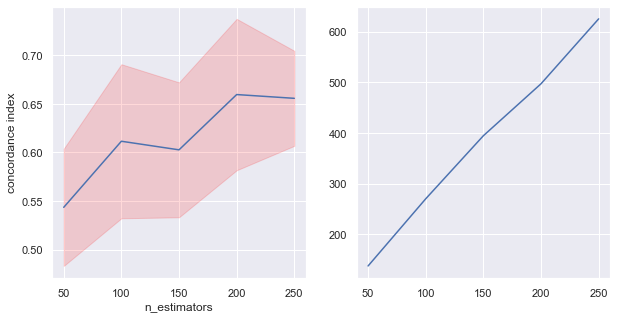

In [15]:
fixed_params = {"loss": "coxph", "max_depth": 5}
n_estimators = np.arange(50, 300, 50)
name = "n_estimators"
scores = hparam_tunning(n_estimators, fixed_params, "n_estimators")

print(f"best {name}: {scores.n_estimators[np.argmax(scores.score)]}")

In [17]:
fixed_params['n_estimators'] = scores.n_estimators[np.argmax(scores.score)]
estimator = GradientBoostingSurvivalAnalysis(**fixed_params).fit(X_train, y_train)
print(f"{estimator.score(X_train, y_train): .5f}; {estimator.score(X_test, y_test): .5f}")

 0.88739;  0.80856


## <font color='yellow'> 8.3 Max Depth </font> 

max_depth tunning: 100%|██████████| 2/2 [17:22<00:00, 521.14s/it]


 0.91845;  0.78383


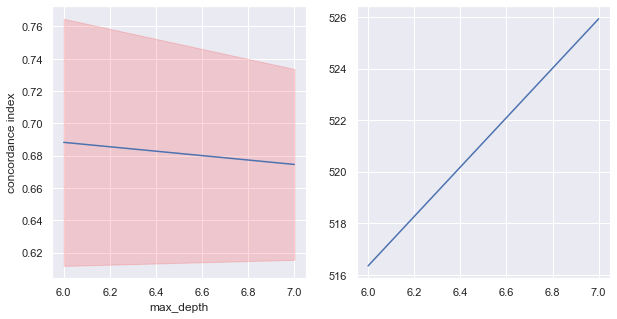

In [21]:
fixed_params = {"loss": "coxph", "max_depth": 5, "n_estimators": 200}
max_depth = np.arange(6, 8, 1)
name = "max_depth"
scores = hparam_tunning(max_depth, fixed_params, name)

fixed_params[name] = scores.loc[:, name][np.argmax(scores.score)]
estimator = GradientBoostingSurvivalAnalysis(**fixed_params).fit(X_train, y_train)
print(f"{estimator.score(X_train, y_train): .5f}; {estimator.score(X_test, y_test): .5f}")

## <font color='yellow'> 8.4 Drop Out </font> 

dropout_rate tunning: 100%|██████████| 10/10 [1:30:23<00:00, 542.39s/it]


 0.88739;  0.80858


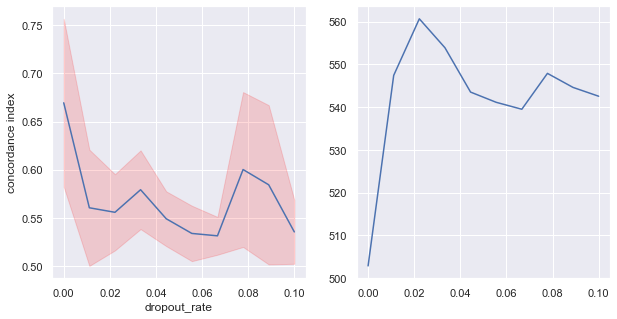

In [28]:
fixed_params = {"loss": "coxph", "max_depth": 5, "n_estimators": 200}
dropout_rate = np.linspace(0, 0.1, 10)
name = "dropout_rate"
scores = hparam_tunning(dropout_rate, fixed_params, "dropout_rate")

fixed_params[name] = scores.loc[:, name][np.argmax(scores.score)]
estimator = GradientBoostingSurvivalAnalysis(**fixed_params).fit(X_train, y_train)
print(f"{estimator.score(X_train, y_train): .5f}; {estimator.score(X_test, y_test): .5f}")